In [37]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
%matplotlib inline
path = '.\\Images'
list_image_files = os.listdir(path)

# 1. Introduction
Moonboards are a climbing board on which problems can be set and shared across the internet. The boards are identical (based on certain hold types), and allow climbers to train and practice on problems created by other users. An image of a typical problem is presented below.

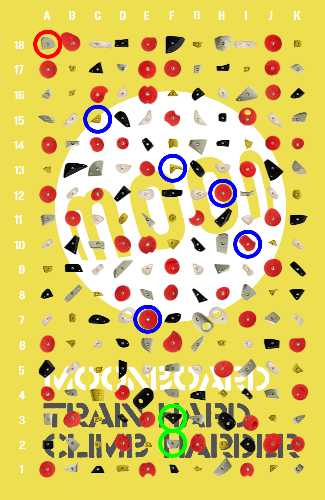

In [16]:
img = Image.open('{0}\\{1}'.format(path,list_image_files[0]))
img=img.resize((int(img.width/2),int(img.height/2)))
img


This presents a few questions:



1) Can a model be created that would grade the climbs based on information? Using an unsupervised model (K-means), would the model classify problems similarly to  humans?

2) Can a simple model be created to predict grading based on features?
Could a Logistic Regression or K-Nearest neighbours model be used to recommend difficulty of climb? Based on which holds are used and the number/distance of holds?

3) Could a neural network be trained to identify climbs based on image data?

Data must be formatted and identified before this analysis can begin. The first stage will be to convert the grading system by Moon into a more usable format. The current grades are formatted like: 6a, 6b, 6b+, 7a, 7c etc, which is not very useful for our work. Instead an alternative grading system (the Hueco V-grade scale) is available that ranges from V0-15.

# 2. Conversion to V-Grades

In [ ]:
# get original scraped data from web
data=pd.read_excel('Moon2017_40degrees_test.xlsx',sheetname='Data')
data.head()

In [ ]:
# get conversion from font to v-grade scale
conversion=pd.read_excel('Moon2017_40degrees_test.xlsx',sheetname='Conversion')
conversion.head(4)

In [ ]:
# Add V-grades to the dataframe
m,n = data.shape
v_grades = np.array([int(conversion[conversion['Font_Grade']==x]['V_Grade']) for x in data['Grade']])
data['V_Grades'] = v_grades
data.head()

# 3. Identify number of Holds
- Scraped data is formatted and saved into new excel workbook.
- Amount of holds is identified of each type for each image

In [ ]:
def hold_identify(path,image_name):
    """Function takes in path and image name and returns red,green,blue holds
    Parameters
    ----------
    path : string
        path of image file
    image_name : string
        image file name
    Returns
    ----------
    [red,green,blue] : list of ints
        red holds, green holds, blue holds
    """
    imag = Image.open("{0}\\{1}".format(path,image_name))
    image_array = np.array(imag.getdata())
    red = image_array[(image_array[:,0]==255)&(image_array[:,1]==0)&(image_array[:,2]==0)&(image_array[:,3]==255),:].shape
    red = red[0]
    red = int(red/1050)
    green = image_array[(image_array[:,0]==0)&(image_array[:,1]==255)&(image_array[:,2]==0)&(image_array[:,3]==255),:].shape
    green = green[0]
    green = int(green/1050)
    blue = image_array[(image_array[:,0]==0)&(image_array[:,1]==0)&(image_array[:,2]==255)&(image_array[:,3]==255),:].shape
    blue = blue[0]
    blue = int(blue/1050)
    #print(list_image_files[i])
    #print('Red: {0},Green: {1},Blue: {2}'.format(red,green,blue))
    return [red,green,blue]

In [ ]:
# create an array of all the rgb holds
rgb_array=[]
for image in data['Image_Name']:
    imag = '{0}.png'.format(image)
    rgb_array.append(hold_identify(path,imag))
rgb_array=np.array(rgb_array)

In [ ]:
# Add hold information to the dataframe
data['red']=rgb_array[:,0]
data['green']=rgb_array[:,1]
data['blue']=rgb_array[:,2]
data.head()
data.to_excel('formatted_climbing_data.xlsx')

# 4. Initial Data Summary
- reload formatted data
- histogram & boxplot of data

In [69]:
data = pd.read_excel('formatted_climbing_data.xlsx')

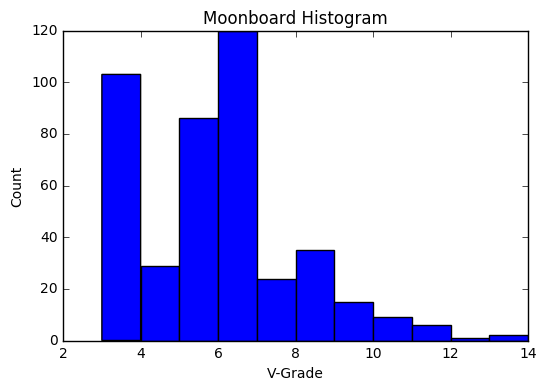

In [3]:
plt.hist(data['V_Grades'],bins=11)
plt.title('Moonboard Histogram')
plt.xlabel('V-Grade')
plt.ylabel('Count')
plt.show()

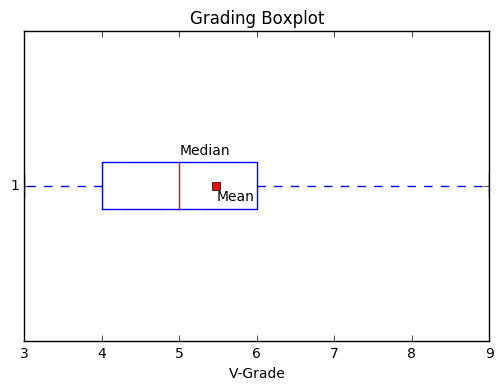

In [4]:
grade_mean = np.mean(data['V_Grades'])
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(data['V_Grades'],vert=False,showfliers=False,showmeans=True)
plt.title('Grading Boxplot')
plt.xlabel('V-Grade')
ax.annotate('Median',(np.median(data['V_Grades']),1.1))
ax.annotate('Mean',(grade_mean,0.95))
plt.show()

Difficulty of problems is not normally distributed. It is right tailed. This is unsurprising, as the entry levelfor training on a moon board is quite high, and there are no lower grade problems. We see two particular peaks in the histogram. The first around the lowest level that people are setting (V3). The second around the point that most individuals are training at (V6). What should be noted is that users may often "try out" the moonboard, setting problems at a lower grade, rather than consistently using and training on it. This leads to a large spike around the low end. If these were to be disregarded then there would be a more normally distributed range of grades.

# 5. Additional Features Identification
- Find key statistics for the problem (min distance, max distance, mean distance, median distance, range of distances, min & max angle between holds, mean angle)

# 5.1  Test case
- Using one test problem to test if additional information can be sourced
- Can we identify pixel position of centre of holds? To identify the centre point of each hold we will use the K-means clustering algorithm to identify the centre point of each climbing hold.

In [33]:
# load the data and create an array of zeros which we will fill with binary data i.e. is a hold or not
test_image_name = list_image_files[0]
test_image = Image.open("{0}\\{1}".format(path,test_image_name))
test_image_data = np.array(test_image.getdata())
test_image_zeros = np.zeros(len(test_image_data))
# create relevant dictionaries for colours
rgb_dic = {'red' : [255,0,0,255],'green' : [0,255,0,255],'blue' : [0,0,255,255]}

# format our array to contain an rgb flag for each pixel
for key in rgb_dic.keys():
    test_image_zeros[(test_image_data[:,0]==rgb_dic[key][0])&(test_image_data[:,1]==rgb_dic[key][1])&(test_image_data[:,2]==rgb_dic[key][2]) & (test_image_data[:,3]==rgb_dic[key][3])]=1
test_image_zeros  = test_image_zeros.reshape(test_image.height,test_image.width)
test_image_zeros.shape

(1000, 650)

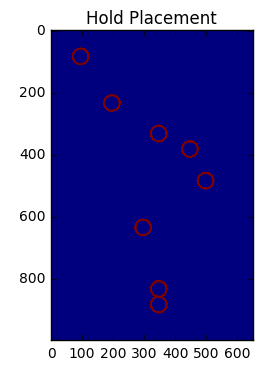

In [34]:
plt.title('Hold Placement')
plt.imshow(test_image_zeros)
plt.show()

In [35]:
# fit the pixel locations to a KMeans clustering model to find centre points
y,x=np.where(test_image_zeros==1)
m=x.size
x=x.reshape(m,1)
y=y.reshape(m,1)
YX=np.concatenate((y,x),axis=1)
hold_kmeans=KMeans(n_clusters=8)
hold_kmeans.fit(YX)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

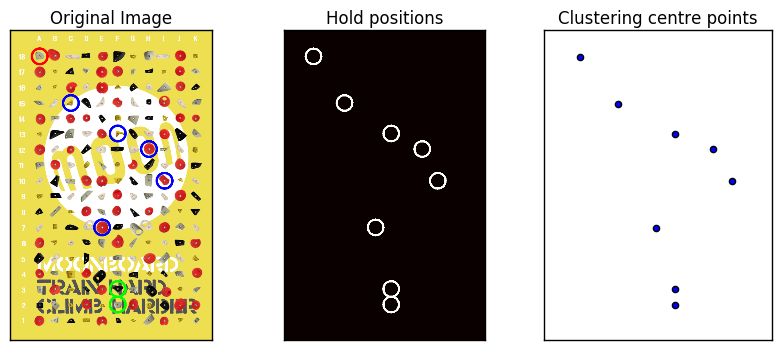

In [301]:
# Plot the points for comparison
t=hold_kmeans.cluster_centers_
#invert the height
t[:,0]=1000-t[:,0]
# Create graphs
orig_img = mpimg.imread("{0}\\{1}".format(path,test_image_name))
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(131)
plt.title('Original Image')
fig1 = plt.imshow(orig_img)
fig1.set_cmap('hot')
fig1.axes.get_xaxis().set_visible(False)
fig1.axes.get_yaxis().set_visible(False)
ax2 = plt.subplot(132)
plt.title('Hold positions')
fig2 = plt.imshow(test_image_zeros)
fig2.set_cmap('hot')
fig2.axes.get_xaxis().set_visible(False)
fig2.axes.get_yaxis().set_visible(False)
ax3=plt.subplot(133)
plt.title('Clustering centre points')
fig3 = plt.scatter(t[:,1],t[:,0])
fig3.set_cmap('hot')
fig3.axes.get_xaxis().set_visible(False)
fig3.axes.get_yaxis().set_visible(False)
plt.show()

In [283]:
#sort the clustering centres by the height of the hold
hold_ctr = t[t[:,0].argsort()]
# find distance & angle between each consecutive holds
height,width = hold_ctr.shape
distance_l = []
angle_l = []
for h in range(height-1):
    first = hold_ctr[h,:]
    second = hold_ctr[h+1,:]
    fs=np.abs(second-first)
    o=fs[0]
    a=fs[1]
    distance = np.sqrt(o**2+a**2)
    angle = np.degrees(np.arctan(o/a))
    distance_l.append(distance)
    angle_l.append(angle)
print(distance_l)
print(angle_l)

[53.3830991540247, 201.1254308047181, 250.00000000000242, 113.5957745693033, 111.80339887499183, 179.2039042124741, 180.2775637732084]
[89.96375353283094, 75.59933422581393, 36.86989764584367, 63.886087369709145, 26.56505117707739, 33.17151567787281, 56.309932474022254]


In [315]:
print(max(distance_l),np.mean(distance_l),np.std(distance_l),np.mean(angle_l))

250.00000000000242 155.62702448410326 61.273203451241535 54.62365315759575


# 5.2 Data extraction build
- Constructing an algorithm to run the above analysis for all cases and output data

In [33]:
def get_image_data(path,image_name,hold_number):
    """
    Parameters
    -----------
    path : folder of file location
    image_name : file name image
    Returns
    -----------
    stat_arr : array of statistical data in the format:
    max_distance,mean_distance,std_distance,mean_angle"""
    # step 1 load image
    image_open = Image.open("{0}\\{1}".format(path,image_name))
    image_data = np.array(image_open.getdata())
    # create relevant dictionaries for colours
    rgb_dic = {'red' : [255,0,0,255],'green' : [0,255,0,255],'blue' : [0,0,255,255]}
    # step 2 create binary array of image
    image_binary = np.zeros(len(image_data))
    for key in rgb_dic.keys():
        image_binary[(image_data[:,0]==rgb_dic[key][0])&(image_data[:,1]==rgb_dic[key][1])&(image_data[:,2]==rgb_dic[key][2]) & (image_data[:,3]==rgb_dic[key][3])]=1
    image_binary  = image_binary.reshape(image_open.height,image_open.width)
    # step 3 locate centre of each cluster
    # fit the pixel locations to a KMeans clustering model to find centre points
    y,x=np.where(image_binary==1)
    m=x.size
    x=x.reshape(m,1)
    y=y.reshape(m,1)
    YX=np.concatenate((y,x),axis=1)
    hold_kmeans=KMeans(n_clusters=hold_number)
    hold_kmeans.fit(YX)
    hold_ctr =hold_kmeans.cluster_centers_
    # invert the height
    hold_ctr[:,0]=1000-hold_ctr[:,0]
    # sort by height
    hold_ctr = hold_ctr[hold_ctr[:,0].argsort()]
    # step 4 find distances and angles between each consecutive cluster (hold)
    height,width = hold_ctr.shape
    distance_l = []
    angle_l = []
    for h in range(height-1):
        first = hold_ctr[h,:]
        second = hold_ctr[h+1,:]
        fs=np.abs(second-first)
        o=fs[0]
        a=fs[1]
        distance = np.sqrt(o**2+a**2)
        angle = np.degrees(np.arctan(o/a))
        distance_l.append(distance)
        angle_l.append(angle)
    # step 5 output statistics
    #max_distance,mean_distance,std_distance,mean_angle
    stat_arr = np.array([[np.max(distance_l),np.mean(distance_l),np.std(distance_l),np.mean(angle_l)]])
    return stat_arr

In [34]:
# testing function matches back to previous build
get_image_data(path,list_image_files[0],8)

array([[250.        , 155.79659657,  61.42365252,  54.62229636]])

# 5.3 Data Extraction run

In [10]:
data['total_holds']=np.sum(data[['red','green','blue']],axis=1)

In [11]:
data.head()

,Climb,Grade,Setter,Image_Name,V_Grades,red,green,blue,total_holds
0,THUNDERBUM CORRECTED,7B+,NICK,12,8,1,2,5,8
1,THUNDERBUM,7B+,NICK,13,8,1,2,4,7
2,JIMMY SIMMY (CORRECTED),7C+,NICK,14,10,1,2,5,8
3,JIM SIM,7C+,NICK,15,10,1,2,5,8
4,BANG FER YER BUCK,7C,NICK,16,9,1,2,5,8


In [16]:
# set index of data so that can easily select and join with other data later
data=data.set_index('Image_Name')

In [37]:
# Loop through all entries from data  and apply algorithm to find max/mean/std data
first = True
for name in data.index:
    hold_number = int(data[data.index==name]['total_holds'])
    image_name = '{0}.png'.format(name)
    result = get_image_data(path,image_name,hold_number)
    result = np.concatenate((np.array([[name]]),result),axis=1)
    if first == True:
        result_arr = result
        first = False
    else:
        result_arr = np.concatenate((result_arr,result),axis=0)
print('Result array constructed')

C:\Users\Frank\Anaconda3\lib\site-packages\ipykernel\__main__.py:46: RuntimeWarning: divide by zero encountered in double_scalars


Result array constructed


In [40]:
result_df = pd.DataFrame(result_arr,columns=['Image_Name','Max_dist','Mean_dist','Std_dist','Mean_angle'])

In [44]:
image_name=result_df['Image_Name']
result_df['Image_Name']=image_name.astype('O')

In [56]:
result_df.head()

,Image_Name,Max_dist,Mean_dist,Std_dist,Mean_angle
0,12.0,360.583532,232.567138,83.573119,29.372603
1,13.0,404.083621,270.110113,100.113647,28.068704
2,14.0,292.581613,206.198514,74.951268,27.928098
3,15.0,335.387608,219.267223,80.163985,26.722804
4,16.0,318.879195,191.677797,78.213798,44.116852


In [61]:
# set the indexes to match
result_df=result_df.set_index(data.index)
# drop the now unused Image_Name column from our data frame
result_df = result_df.drop('Image_Name',axis=1)
# concatenate the two dataframes together
data=pd.concat((data,result_df),axis=1)

In [68]:
# save the data to excel
data.to_excel('formatted_climbing_data.xlsx')

# 6. Feature Clustering
- Do climbs cluster by a set of features
- Do these features align at all with climbing grade?

In [29]:
data=pd.read_excel('formatted_climbing_data.xlsx')
# How many grades are there to potentially cluster around?
grade_number = pd.unique(data['V_Grades']).size
print(grade_number)
# We will use a subset of features: total_holds, Max_dist, Mean_dist, Std_dist, Mean_angle
training_df = data[['total_holds','Max_dist','Mean_dist','Std_dist','Mean_angle']]
training_grade_df = data['V_Grades']
training_df.head()

11


,total_holds,Max_dist,Mean_dist,Std_dist,Mean_angle
0,8,360.583532,232.567138,83.573119,29.372603
1,7,404.083621,270.110113,100.113647,28.068704
2,8,292.581613,206.198514,74.951268,27.928098
3,8,335.387608,219.267223,80.163985,26.722804
4,8,318.879195,191.677797,78.213798,44.116852


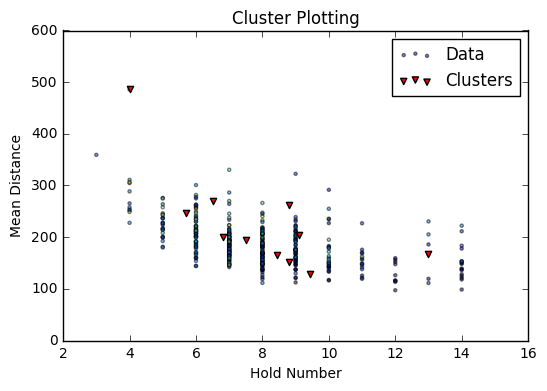

In [54]:
# fit and graph model
clustering_model = KMeans(n_clusters=grade_number)
clustering_model.fit(training_df)
cluster_ctr = clustering_model.cluster_centers_
plt.scatter(training_df['total_holds'],training_df['Mean_dist'],c=training_grade_df/100,marker='.',alpha=0.5)
plt.legend()
plt.scatter(cluster_ctr[:,0],cluster_ctr[:,2],c='r',marker='v')
plt.legend(['Data','Clusters'])
plt.title('Cluster Plotting')
plt.ylabel('Mean Distance')
plt.xlabel('Hold Number')

plt.show()

# 7. Logistic Regression
- Can a logistic regression be used to suitably predict grades based on the data?

# 7.1 Training

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [109]:
logistic_regression = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(training_df, training_grade_df, test_size=0.33, random_state=42)

In [113]:
logistic_regression.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
prediction = logistic_regression.predict(X_test)

# 7.2 Results
With an accuracy score of 41% this may not seem particularly high, but it does at least show some ability to identify based on the data we have. It is more than 4 times more accurate than random chance.

In [116]:
accuracy_score(y_test,prediction)

0.4084507042253521

# 8. KNeighbors
- Going to attempt to create a prediction model based on the K Nearest Neighbors algorithm
- Will attempt to identify the most accurate level of recommendation

# 8.1 Model Training
- Using the elbow method will attempt to identify the best K number to use

In [10]:
data=pd.read_excel('formatted_climbing_data.xlsx')
# We will use a subset of features: total_holds, Max_dist, Mean_dist, Std_dist, Mean_angle
training_df = data[['total_holds','Max_dist','Mean_dist','Std_dist','Mean_angle']]
training_grade_df = data['V_Grades']
X_train, X_test, y_train, y_test = train_test_split(training_df, training_grade_df, test_size=0.33, random_state=42)
training_df.head()

,total_holds,Max_dist,Mean_dist,Std_dist,Mean_angle
0,8,360.583532,232.567138,83.573119,29.372603
1,7,404.083621,270.110113,100.113647,28.068704
2,8,292.581613,206.198514,74.951268,27.928098
3,8,335.387608,219.267223,80.163985,26.722804
4,8,318.879195,191.677797,78.213798,44.116852


In [6]:
from sklearn.neighbors import KNeighborsClassifier

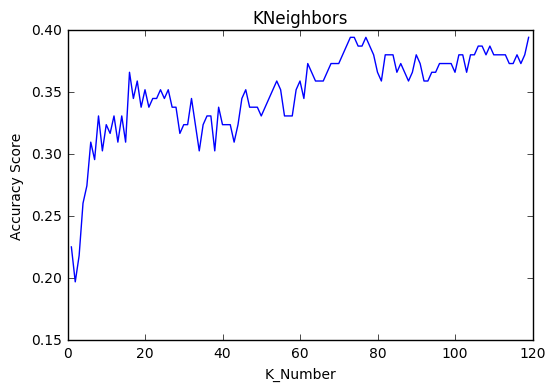

In [21]:
# Going to use the elbow method to see if we can identify the most accurate number of neighbors
k_range = np.arange(1,120)
accuracy_list = []
for k in k_range:
    KN_model = KNeighborsClassifier(n_neighbors=k)
    KN_model.fit(X_train,y_train)
    KN_prediction = KN_model.predict(X_test)
    accuracy_list.append(accuracy_score(y_test,KN_prediction))
plt.title('KNeighbors')
plt.xlabel('K_Number')
plt.ylabel('Accuracy Score')
plt.plot(k_range,accuracy_list)
plt.show()

# 8.2 Result
The K Number with the highest score is 72. As can be seen from the graph there is a particular peak around the 70-80 region,before dropping and levelling off. If more data was obtained it would be interesting to see if this model could be improved further.

The accuracy score only peaks at 39%, which is slightly worse than the Logistic Regression Model.

In [26]:
print('maximum accuracy: {0}'.format(round(np.max(accuracy_list),6)))
print('Best K Neighbors: {0}'.format(np.argmax(accuracy_list)))

maximum accuracy: 0.394366
Best K Neighbors: 72


# 8.3 Next Steps
Possible improvements to the model could be made by looking at hold type/quality. Holds could be defined as white/black/red/yellow. Does use of one hold type more than others also weight a climb to a certain difficulty?

1. Identify holds position, graph them to ensure that they do not overlap.
2. Offset background, so image clustering isn't affected.
3. Split Image into sub-images, find centre points. Average the sub-image pixels.
4. Cluster images by average pixel of each sub-image.
5. Check results


In [3]:
# Load Image
image_file = 'base_image.png'
image_open = Image.open('{0}'.format(image_file),'r')
image_array = np.array(image_open)
n,m = image_open.size
image_open.close()
image_array = image_array.reshape((m*n,4))
image_array = image_array.astype('uint8')

# 8.3.1 Identify Hold Position
Manual investigation shows that each hold position is around 50x50 pixels in shape. The image can therefore be split into sub-images of 50x50.

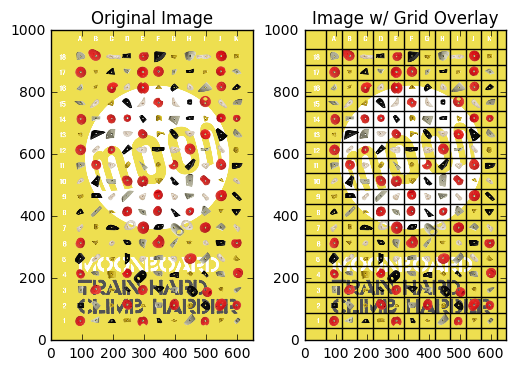

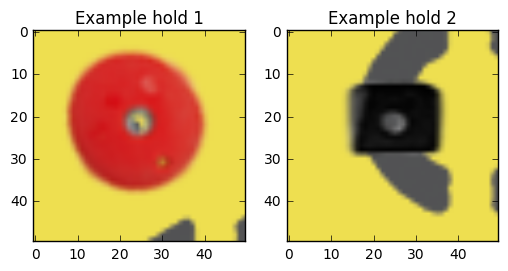

In [4]:
# Going to look at splitting images into sub-images
#plt.title('Base Image')
ax=plt.subplot(121)
plt.title('Original Image')
fig1=plt.imshow(np.flip(image_array.reshape((m,n,4)),0))
plt.ylim(0,1000)
plt.xlim(0,650)
plt.subplot(122)
fig2=plt.imshow(np.flip(image_array.reshape((m,n,4)),0))
plt.title('Image w/ Grid Overlay')
plt.ylim(0,1000)
plt.xlim(0,650)
# Split the image into boxes:
for i in range(12):
    plt.plot([70+i*50,70+i*50],[0,1000],color='k')
for i in range(19):
    plt.plot([0,650],[40+i*50,40+i*50],color='k')
plt.show()
# Create sub-images
plt.subplot(121)
plt.title('Example hold 1')
image_array_2 = np.flip(image_array.reshape((m,n,4)),0)
sub_array = image_array_2[40:90,70:120,:]
fig3=plt.imshow(sub_array)
plt.subplot(122)
plt.title('Example hold 2')
sub_array = image_array_2[90:140,70:120,:]
fig4=plt.imshow(sub_array)
plt.show()

# 8.3.2 Offset Background

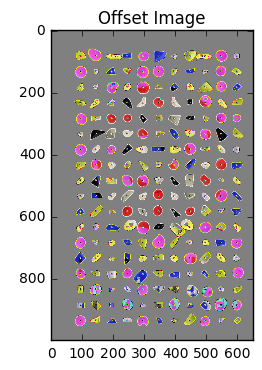

In [51]:
# Open the base image with holds on
image_open = Image.open('{0}'.format(image_file),'r')
image_array1 = np.array(image_open)
n,m = image_open.size
image_open.close()
image_array1 = image_array1.reshape((m*n,4))
image_array1 = image_array1.astype('uint8')
# Open the base image without holds on
image_file_base = 'base_board.png'
image_open = Image.open('{0}'.format(image_file_base),'r')
image_array2 = np.array(image_open)
n,m = image_open.size
image_open.close()
image_array2 = image_array2.reshape((m*n,4))
image_array2 = image_array2.astype('uint8')
plt.title('Offset Image')
comparison_array = image_array1[:,:3] - image_array2[:,:3]
comparison_array = np.concatenate((comparison_array,image_array1[:,3].reshape(-1,1)),axis=1)
comparison_array[(comparison_array[:,0]==0)&(comparison_array[:,1]==0)&(comparison_array[:,2]==0),:]=np.array([128,128,128,255])
fig=plt.imshow(comparison_array.reshape((m,n,4)))

In [52]:
# reshape array to ensure correct
comparison_array = np.flip(comparison_array.reshape(m,n,4),axis=0)

# 8.3.3 Split Image into Sub-images
- split into sub-images
- find centre points
- average the image across pixels

In [73]:
initital_run = True
# create all sub_images
for i in range(11):
    for j in range(18):
        sub_image = comparison_array[40+j*50:40+(1+j)*50,70+i*50:70+(i+1)*50,:]
        mid_point = np.array([np.mean([40+j*50,40+(1+j)*50]),np.mean([70+i*50,70+(i+1)*50])])
        x,y,z = sub_image.shape
        sub_image = sub_image.reshape(x*y,z,1)
        mid_point = mid_point.reshape(-1,1)
        if  initital_run == True:
            output_array = sub_image.copy()
            output_centre_array = mid_point.copy()
            initital_run = False
        else:
            output_array = np.concatenate((output_array,sub_image),axis=2)
            output_centre_array = np.concatenate((output_centre_array,mid_point),axis=1)
# average the pixel values
print('output array shape: {0}'.format(output_array.shape))
# Average across pixels and transpose to dimensions: sub-image x pixel
out_mean = np.mean(output_array,axis=0)
out_mean = out_mean.T

output array shape: (2500, 4, 198)


# 8.3.4 Cluster Image by Pixels

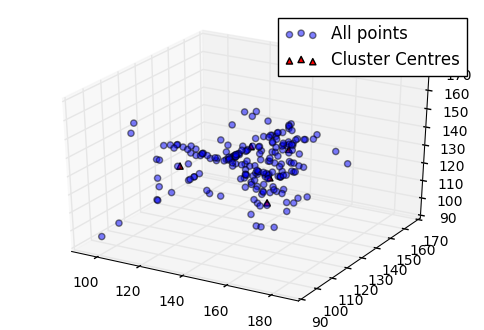

In [74]:
# there are 5 hold types
clustering_model = KMeans(n_clusters=5)
# fit and predict for each sub-image
clustering_model.fit_predict(out_mean)
cluster_ctr = clustering_model.cluster_centers_
fig = plt.figure()
plt.title('Cluster points')
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(out_mean[:,0],out_mean[:,1],out_mean[:,2],alpha=0.5)
ax.scatter3D(cluster_ctr[:,0],cluster_ctr[:,1],cluster_ctr[:,2],c='r',alpha=1,marker='^')
plt.legend(['All points', 'Cluster Centres'])

# 8.3.5 Check Results
The returned classification is not totally accurate, but will be a useful step in adding criteria to the models. The worry is that the model has only really classified 4 types of holds. Due to image deduction a lot of  the red holds are now pink, resulting in what appears to be a separate grouping.

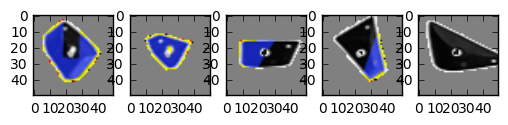

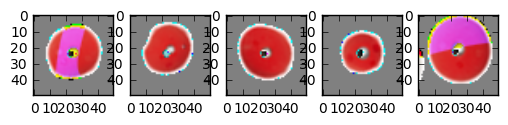

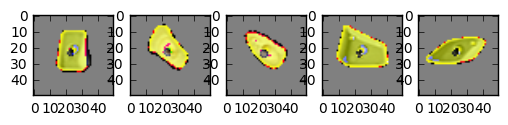

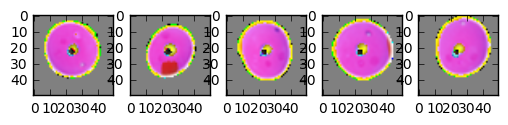

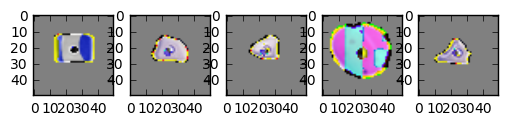

In [68]:
# Look at cluster 0-4
for i in range(5):
    test_array_1 = output_array[:,:,clustering_model.labels_==i]
    for j in range(5):
        plt.subplot(int('15{0}'.format(j+1)))
        sub_array = test_array_1[:,:,j]
        sub_array = sub_array.reshape(50,50,4)
        fig=plt.imshow(sub_array)
    plt.show()


In [78]:
# group the centre points:
centre_point_dic = {}
# centre points logged as y-coordinate,x-coordinate
for i in range(5):
    centre_point_dic[i]=output_centre_array[:,clustering_model.labels_==i].T

In [72]:
# Using example from section 5.1
hold_kmeans.cluster_centers_

array([[237.33896797, 194.38967972],
       [831.26010363, 344.42487047],
       [487.38987567, 494.38987567],
       [637.38987567, 294.38987567],
       [ 87.33896797,  94.38967972],
       [335.38987567, 344.38987567],
       [385.38987567, 444.38987567],
       [884.74263432, 344.36481802]])

In [79]:
centre_point_dic[0].shape

(39, 2)